In [1]:
#!/usr/bin/env python
# coding: utf-8

%load_ext autoreload
%autoreload 2



import torch, datetime, click, pickle, numpy as np
from tqdm import tqdm

torch.set_default_tensor_type(torch.cuda.FloatTensor)

import swyft
from utils import *
from data_mgmt import get_paths, get_ids
from plot import plot_losses
from predict import Predict

In [2]:
DEVICE = 'cuda'


# @click.command()
# @click.option("--m",    type=int, default = 1,  help="Exponent of subhalo mass.")
# @click.option("--nsub", type=int, default = 1,   help="Number of subhaloes.")
# @click.option("--nsim", type=int, default = 100, help="Number of simulations to run.")

# @click.option("--nmc",  type=int, default = 1,   help="Number of mass bins.")
# @click.option("--sigma",   type=float, default = 0.0,   help="Additional noise.")
# @click.option("--npred",  type=int, default = 1,   help="Number of predictions.")

# @click.option("--lr",         type=float, default = 1e-3, help="Learning rate.")
# @click.option("--factor",     type=float, default = 1e-1, help = "Factor of Scheduler")
# @click.option("--patience",   type=int,   default = 5,    help = "Patience of Scheduler")
# @click.option("--max_epochs", type=int,   default = 20,   help = "Max number of epochs.")

# @click.option("--zero", type=str, default = 'real', help="Number of simulations to run.")



# Set definitions (should go to click)
m = 1
nsub = 1
nsim = 1000

nmc = 1
sigma = 0.0
npred = 0

lr = 1e-3
factor = 1e-1
patience = 5
max_epochs = 20

zero = 'toy'

In [3]:
time_start = datetime.datetime.now()


def noise(obs, _= None, sigma_n = sigma):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

# Set definitions (should go to click)
systemname = "ngc4414"


# Set utilities
entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
store_path, dataset_path, mre_path, pred_path = get_paths(entry)

store = swyft.Store.load(path=store_path)
print(f'Store has {len(store)} simulations.')

Loading existing store.
Store has 963 simulations.


In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
config = get_config(systemname, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

Image has L = 40.


In [5]:
dataset = swyft.Dataset.load(
    filename=dataset_path,
    store=store,
    simhook = noise
)

In [6]:
# Load network
print(f'Loading {mre_path}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmc, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
    parameter_transform = CustomParameterTransform(nmc, L, lows, highs),
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading ../data/mre/mre_toy_m_1_nsub_1_nsim_1000_sigma_0.0_nmc_1.pt!


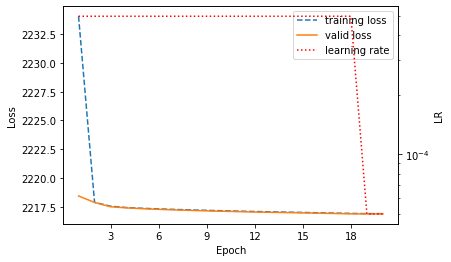

In [7]:
plot_losses(mre, save_name = get_ids(entry)[2])

In [12]:
# Get predictions
predict = Predict(entry, lows, highs, L, dataset, mre)
post_norm, posts, target, obs0, v0, obs0_i = predict()

if npred == 0: npred = len(dataset) 

prior no halo 	0.999375
pario halo 	0.000625
torch.Size([2, 40, 40]) (1, 40, 40)


In [9]:
pred = {
    'post_norm':   np.zeros((npred, *post_norm.shape)),
    'posts':   np.zeros((npred, *posts.shape)),
    'target': np.zeros((npred, *target.shape)),
    'obs0':   np.zeros((npred, *obs0.shape)),
    'v0':     np.zeros((npred, *v0.shape)),
    'obs0_i': np.zeros((npred)),
}

for i in tqdm(range(npred), mininterval = 60): # miniters=int(223265/100)): # loop over number of observations we will take into account
    for name, var in zip(pred.keys(), predict()):
        pred[name][i] = var

100%|██████████| 963/963 [00:13<00:00, 70.65it/s]


In [10]:
pred_path

'../data/pred/pred_toy_m_1_nsub_1_nsim_1000_sigma_0.0_nmc_1_npred_0.pickle'

In [11]:
with open(pred_path, 'wb') as f:
    pickle.dump(pred, f)

print(f" Prediction Done! \n Total prediction time is {str(datetime.datetime.now() - time_start).split('.')[0]}! \n \n ")

 Prediction Done! 
 Total prediction time is 0:00:15! 
 
 
